In [1]:
import numpy as np
import math
import pandas as pd
import matplotlib.pyplot as plt
import random
import pickle

In [2]:
# Initialize Weights
def init_params(layer_size):
    params={}
    for i in range(1,len(layer_size)):
        params["W"+ str(i)]= np.random.randn(layer_size[i], layer_size[i-1])* .01
        #params["W"+ str(i)]= np.random.randint(low = -2, high= 4, size=(layer_size[i], layer_size[i-1]))*.1  # For Debugging
        params["b"+ str(i)]= np.zeros((layer_size[i],1))
    
    return params

In [3]:
# Onehot Encoder
def one_hot(Y, num_channels):
    m= np.shape(Y)[0]
    one_h= np.zeros((num_channels,m))
    index=0
    for i in Y:
        one_h[i, index]=1
        index= index+1
    
    return one_h  

In [4]:
# Sigmoid
def sigmoid(Z):
    sig= 1/ (1+ np.exp(Z))
    
    return sig    

In [5]:
# ReLU
def relu(Z):
    relu= np.maximum(0,Z)
    
    return relu

In [6]:
# Softmax
def softmax(Z):
    soft= np.exp(Z)/ (np.sum(np.exp(Z), axis=0))
    
    return soft

In [7]:
# Activation
def activation(Z, activation):
    if activation== "relu":
        A= relu(Z)
    elif activation== "sigmoid":
        A= sigmoid(Z)
    elif activation== "softmax":
        A=softmax(Z)
    
    return A   

In [8]:
# Softmax Backprop
def softmax_back(dA, caches, layer_num, Y_train):
    al, _, _, _ = caches[layer_num-1]
    sofback= al-Y_train
    
    return sofback

In [9]:
# Relu backprop
def relu_back(dA, caches, layer_num):
    _, _, _, Zl= caches[layer_num-1]
    relback= dA* np.heaviside(Zl, 0)
    
    return relback

In [10]:
# Forward Propagation 
def forward_prop_single(A_prev, W, b):
    Z= np.dot(W, A_prev) + b
    
    return Z

In [11]:
# Forward propagation final
def forw_prop(X_train, layer, params):
    
    layer_dim= layer["Dim"]
    layer_activs= layer["Activs"]
    
    L= len(layer_dim)
    #params= init_params(layer_dim) 
    caches=[]
    A= X_train
    
    for l in range(1, L):
        A_prev=A
        W= params["W" + str(l)]
        b= params["b" + str(l)]
        Z= forward_prop_single(A_prev, W, b)
        A= activation(Z, layer_activs[l-1])
        cache= (A, W, b, Z)
        caches.append(cache)
    
    return caches

In [12]:
# Defining Cost Function
def cost(Y_train, Y, params, lamda):
    m= np.shape(Y_train)[1]
    loss= -np.sum(np.multiply(Y_train, np.log(Y)), axis= 0)
    c= (1/m)*np.sum(loss)
    c= np.squeeze(c)
    reg=0
    for i in range(len(params)//2):
        reg= reg+ np.sum(np.square(params["W" + str(i+1)]))    
    reg=reg* (lamda/(2*m))
    c=c+reg
    
    return c

In [13]:
# Single backprop
def back_prop_single(dA, caches, layer_num, activation, X_train, Y_train, lamda):
    if activation== "relu":
        dZ= relu_back(dA, caches, layer_num)
    elif activation=="softmax":
        dZ= softmax_back(dA, caches, layer_num, Y_train)
    m= np.shape(dA)[1]    
    _, Wl, _, _= caches[layer_num-1]
    
    if layer_num==1:
        al_1= X_train
    else:
        al_1, _, _, _ = caches[layer_num-2]
        
    dW= (1/m)*np.dot(dZ ,np.transpose(al_1)) + (lamda/m)*Wl
    db= (1/m)* np.sum(dZ, axis=1, keepdims=True)
    dAl_1= np.dot(np.transpose(Wl), dZ)
    
    return dW, db, dAl_1, dZ    

In [14]:
# N layer backprop
def back_prop(Y_train, caches, layer, X_train, lamda):
    layer_dim= layer["Dim"]
    layer_activs= layer["Activs"]
    L= len(caches)
    A_L, _, _, _= caches[L-1]
    dA= -(Y_train/A_L) 
    grads={}
    grads["dA"+ str(L)]= dA
    
    for l in range(L, 0, -1):
        dW, db, dA, dZ= back_prop_single(dA, caches, l, layer_activs[l-1], X_train, Y_train, lamda)
        grads["dW" + str(l)]= dW
        grads["db" + str(l)]= db
        grads["dA" + str(l-1)]= dA
        grads["dZ" + str(l)]= dZ
        
    return grads

In [15]:
# Update params
def upd_params(grads, params, l_rate):
    parameters=params.copy()
    L=len(parameters)//2
    for l in range(L):
        parameters["W"+str(l+1)]= parameters["W"+str(l+1)] -l_rate*grads["dW"+str(l+1)]
        parameters["b"+str(l+1)]= parameters["b"+str(l+1)] -l_rate*grads["db"+str(l+1)]
        
    return parameters

In [16]:
# Accuracy
def acc(X_dev, Y_dev, params, layer):
    dev_cache= forw_prop(X_dev, layer, params)
    preds, _, _, _= dev_cache[len(dev_cache)-1]
    preds= np.argmax(preds, axis=0)
    correct= np.sum(preds== Y_dev)
    accurate= correct/ np.shape(Y_dev)[0]
    
    return preds,accurate

In [17]:
#MAIN

# For Debugging 
'''
X_train= np.array([[1, 2, 1], [2, 1, 3], [3, 1, 3], [4, 3, 3]])
Y_train= np.array([[1, 0, 0], [0, 0, 0], [0, 1, 0], [0, 0, 1]])


Y_train= np.array([[0,1,0,0,0,1,0], [0,0,1,0,1,0,0], [0,0,0,1,0,0,1], [1,0,0,0,0,0,0]])
X_train= np.array([[10,80,11,49,15,55,32], [20,70,19,60, 85,16, 43], [30,60,15,70,9,36,69], [40,50,13,38,10,48,24]])
X_mean= np.mean(X_train, axis= 1, keepdims=True)
X_std= np.std(X_train, axis=1, keepdims=True) 
X_train= (X_train-X_mean)/X_std
m_train= 7
'''
# Import and one_hot encoding 
data= pd.read_csv(r'E:\My files\Python\DL\Datasets\MNIST\train.csv')
data= np.array(data)
data= np.transpose(data)
m= np.shape(data)[1]             #Total examples
m_train= 41000                   #Number of examples to be used for training

X_train= data[1:785, 0:m_train]
X_train= X_train/255

Y_train= data[0, 0:m_train]
Y_train_acc= Y_train
Y_train= one_hot(Y_train, 10)

X_dev= data[1:785, m_train:m]
X_dev= X_dev/255
Y_dev= data[0, m_train:m]


#Layer Data
layer_data={ "Dim": [784,300,10], "Activs": ["relu", "softmax"]}


#Hyperparameters
epochs= 30                         #Iterations
rate = 0.5                         #learning rate
batch_size= 512                    #Mini-batch size
mini_batch= m_train // batch_size  #Number of mini-batches
lamda= 0                           #Regularization parameter

#Initialize parameters
params= init_params(layer_data["Dim"])
cost_history=[]
dev_acc=[]
train_acc=[]
print(params)

#Training the model. COMMENT WHEN IN INFERENCE MODE.
for ep in range(epochs):
   
    print("Epoch "+str(ep+1))
    
    #Adaptive Learning Rate
    if (ep+1)%26 ==0:
        rate = rate/2
            
    for batch in range(mini_batch):
        start_index= batch_size*batch
        end_index= min((batch+1)*batch_size, m_train)
       
        X_train_batch = X_train[:, start_index: end_index]
        Y_train_batch = Y_train[:, start_index: end_index]
        
   
        # Forward propagation
        for_cache= forw_prop(X_train_batch, layer_data, params)
        #for i in range(len(for_cache)):
            #print("A"+str(i+1),",W"+str(i+1), ",b"+str(i+1),",Z"+str(i+1),"\n", for_cache[i], '\n')
        Y,_,_,_= for_cache[-1]

        
        # Cost
        cost_forward= cost(Y_train_batch, Y, params, lamda)
        print("Cost:", cost_forward)
        cost_history.append(cost_forward)

        
        # Back Propagation
        gradients= back_prop(Y_train_batch, for_cache, layer_data, X_train_batch, lamda)
    
        #for i in  range(len(for_cache), 0, -1):
            #print("dA"+str(i)+": " ,gradients["dA"+str(i)], "\n")
            #print("dZ"+str(i)+": " ,gradients["dZ"+str(i)], "\n")
            #print("dW"+str(i)+": " ,gradients["dW"+str(i)], "\n")
            #print("db"+str(i)+": " ,gradients["db"+str(i)], "\n")

        # Update Parameters
        params = upd_params(gradients, params, rate)
        #print(params.items())
        
        
        _, accuracy= acc(X_dev, Y_dev, params, layer_data)
        dev_acc.append(accuracy)
        print("Dev Accuracy:", accuracy)
        
        _, accuracy= acc(X_train, Y_train_acc, params, layer_data)
        train_acc.append(accuracy)
        print("Train Accuracy:", accuracy, "\n")

{'W1': array([[ 0.00626157, -0.00821519,  0.00838877, ..., -0.0066597 ,
        -0.00358066,  0.01236752],
       [-0.00611804, -0.00289845,  0.00639903, ..., -0.02418403,
         0.0078644 , -0.01526269],
       [-0.01032043, -0.00505512, -0.00089463, ...,  0.00832909,
        -0.00843116, -0.00543243],
       ...,
       [-0.00957844,  0.01299202, -0.00457953, ...,  0.01345784,
         0.00067388,  0.0051955 ],
       [-0.00756114,  0.00543481,  0.01929015, ...,  0.00074939,
        -0.00480791,  0.00520354],
       [ 0.0026948 , -0.01007359,  0.0112613 , ...,  0.00821563,
         0.00212426, -0.00996662]]), 'b1': array([[0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0

Train Accuracy: 0.8344146341463414 

Cost: 0.5193144552984402
Dev Accuracy: 0.826
Train Accuracy: 0.8344634146341463 

Cost: 0.6181713771358981
Dev Accuracy: 0.808
Train Accuracy: 0.814560975609756 

Cost: 0.5387701568776793
Dev Accuracy: 0.769
Train Accuracy: 0.7832439024390244 

Cost: 0.5644434041642934
Dev Accuracy: 0.78
Train Accuracy: 0.791609756097561 

Cost: 0.6234616612847514
Dev Accuracy: 0.81
Train Accuracy: 0.8170731707317073 

Cost: 0.6121346822599308
Dev Accuracy: 0.805
Train Accuracy: 0.8006585365853659 

Cost: 0.6138135821549383
Dev Accuracy: 0.806
Train Accuracy: 0.8136585365853658 

Cost: 0.6302869674529369
Dev Accuracy: 0.805
Train Accuracy: 0.8004634146341464 

Cost: 0.5557641658325919
Dev Accuracy: 0.797
Train Accuracy: 0.8022682926829269 

Cost: 0.6548808886506348
Dev Accuracy: 0.753
Train Accuracy: 0.743609756097561 

Cost: 0.777143846371882
Dev Accuracy: 0.787
Train Accuracy: 0.7915121951219513 

Cost: 0.876173140428511
Dev Accuracy: 0.859
Train Accuracy: 0.85485

Train Accuracy: 0.9176829268292683 

Cost: 0.2925243453591634
Dev Accuracy: 0.909
Train Accuracy: 0.9141951219512195 

Cost: 0.3026441341248988
Dev Accuracy: 0.899
Train Accuracy: 0.9047073170731708 

Cost: 0.3292581341352822
Dev Accuracy: 0.904
Train Accuracy: 0.9117804878048781 

Cost: 0.2951012595002693
Dev Accuracy: 0.912
Train Accuracy: 0.9169512195121952 

Cost: 0.31274574158433877
Dev Accuracy: 0.913
Train Accuracy: 0.9189512195121952 

Cost: 0.2756139745652153
Dev Accuracy: 0.916
Train Accuracy: 0.9182682926829269 

Cost: 0.2607363925036358
Dev Accuracy: 0.91
Train Accuracy: 0.9178780487804878 

Cost: 0.28365489575282554
Dev Accuracy: 0.914
Train Accuracy: 0.9189756097560976 

Cost: 0.252135644329424
Dev Accuracy: 0.918
Train Accuracy: 0.9205853658536586 

Cost: 0.34628326757853367
Dev Accuracy: 0.9
Train Accuracy: 0.9075609756097561 

Cost: 0.3070758854546787
Dev Accuracy: 0.917
Train Accuracy: 0.9209512195121952 

Cost: 0.2574774708294636
Dev Accuracy: 0.911
Train Accuracy: 0

Train Accuracy: 0.9337317073170732 

Cost: 0.21596134585992488
Dev Accuracy: 0.929
Train Accuracy: 0.9364878048780488 

Cost: 0.19462600004539224
Dev Accuracy: 0.928
Train Accuracy: 0.9344146341463415 

Cost: 0.28857836292000444
Dev Accuracy: 0.932
Train Accuracy: 0.9343414634146342 

Cost: 0.24444074551848854
Dev Accuracy: 0.927
Train Accuracy: 0.9361463414634147 

Epoch 4
Cost: 0.21656705831138964
Dev Accuracy: 0.926
Train Accuracy: 0.935 

Cost: 0.22843434303097077
Dev Accuracy: 0.927
Train Accuracy: 0.9370975609756098 

Cost: 0.19315911723952459
Dev Accuracy: 0.927
Train Accuracy: 0.9392682926829268 

Cost: 0.2287551948627928
Dev Accuracy: 0.932
Train Accuracy: 0.9351463414634147 

Cost: 0.24738831438215828
Dev Accuracy: 0.93
Train Accuracy: 0.9360487804878049 

Cost: 0.19042144816151796
Dev Accuracy: 0.927
Train Accuracy: 0.9355121951219513 

Cost: 0.20683678748602818
Dev Accuracy: 0.932
Train Accuracy: 0.938170731707317 

Cost: 0.2642605332685911
Dev Accuracy: 0.927
Train Accurac

Train Accuracy: 0.9469024390243902 

Cost: 0.17648750291073892
Dev Accuracy: 0.939
Train Accuracy: 0.9475853658536585 

Cost: 0.16122806312487215
Dev Accuracy: 0.943
Train Accuracy: 0.945170731707317 

Cost: 0.1742674893074676
Dev Accuracy: 0.937
Train Accuracy: 0.9494146341463414 

Cost: 0.15248059696008642
Dev Accuracy: 0.942
Train Accuracy: 0.9494634146341463 

Cost: 0.18166243993192138
Dev Accuracy: 0.944
Train Accuracy: 0.9452682926829268 

Cost: 0.2111200623423409
Dev Accuracy: 0.94
Train Accuracy: 0.9480975609756097 

Cost: 0.1461726883930869
Dev Accuracy: 0.946
Train Accuracy: 0.9494390243902439 

Cost: 0.17702417991928462
Dev Accuracy: 0.943
Train Accuracy: 0.9484146341463414 

Cost: 0.20835797431169606
Dev Accuracy: 0.935
Train Accuracy: 0.9464390243902439 

Cost: 0.25776381268125265
Dev Accuracy: 0.938
Train Accuracy: 0.9452195121951219 

Cost: 0.20788495864543008
Dev Accuracy: 0.942
Train Accuracy: 0.9485853658536585 

Cost: 0.15378619719655248
Dev Accuracy: 0.931
Train Acc

Train Accuracy: 0.9553170731707317 

Cost: 0.17570811069355102
Dev Accuracy: 0.949
Train Accuracy: 0.9570975609756097 

Cost: 0.12914460678296213
Dev Accuracy: 0.95
Train Accuracy: 0.9564634146341463 

Cost: 0.1525057309762306
Dev Accuracy: 0.948
Train Accuracy: 0.9567317073170731 

Cost: 0.13101499157636265
Dev Accuracy: 0.943
Train Accuracy: 0.9558048780487804 

Cost: 0.16415642030919791
Dev Accuracy: 0.949
Train Accuracy: 0.9572195121951219 

Cost: 0.17255034659470195
Dev Accuracy: 0.946
Train Accuracy: 0.9570975609756097 

Cost: 0.2019184105808377
Dev Accuracy: 0.949
Train Accuracy: 0.9552926829268292 

Cost: 0.1569164459738847
Dev Accuracy: 0.947
Train Accuracy: 0.9551951219512195 

Cost: 0.16751519005060184
Dev Accuracy: 0.948
Train Accuracy: 0.9563170731707317 

Cost: 0.19060535933757622
Dev Accuracy: 0.945
Train Accuracy: 0.9557073170731707 

Cost: 0.1826786260637166
Dev Accuracy: 0.946
Train Accuracy: 0.9548780487804878 

Cost: 0.17964776871581503
Dev Accuracy: 0.943
Train Acc

Train Accuracy: 0.9632682926829268 

Cost: 0.12483265949305324
Dev Accuracy: 0.958
Train Accuracy: 0.9631951219512195 

Cost: 0.13547132123142966
Dev Accuracy: 0.954
Train Accuracy: 0.9611463414634146 

Cost: 0.15805641019750755
Dev Accuracy: 0.952
Train Accuracy: 0.962390243902439 

Cost: 0.12067537178906133
Dev Accuracy: 0.953
Train Accuracy: 0.9641463414634146 

Cost: 0.117798689370135
Dev Accuracy: 0.953
Train Accuracy: 0.9640731707317073 

Cost: 0.12092726613969854
Dev Accuracy: 0.951
Train Accuracy: 0.9631219512195122 

Cost: 0.12585191978976132
Dev Accuracy: 0.952
Train Accuracy: 0.9641951219512195 

Cost: 0.13640211116896245
Dev Accuracy: 0.952
Train Accuracy: 0.9636585365853658 

Cost: 0.10694256170880641
Dev Accuracy: 0.953
Train Accuracy: 0.9634634146341463 

Cost: 0.16558164581619655
Dev Accuracy: 0.949
Train Accuracy: 0.9614634146341463 

Cost: 0.12576990672331306
Dev Accuracy: 0.952
Train Accuracy: 0.9625365853658536 

Cost: 0.11975755206850155
Dev Accuracy: 0.957
Train A

Train Accuracy: 0.9660487804878048 

Cost: 0.12014320169783634
Dev Accuracy: 0.954
Train Accuracy: 0.9663170731707317 

Cost: 0.09943327367029703
Dev Accuracy: 0.956
Train Accuracy: 0.967609756097561 

Cost: 0.1619752853684691
Dev Accuracy: 0.957
Train Accuracy: 0.9687317073170731 

Cost: 0.1262531766371652
Dev Accuracy: 0.951
Train Accuracy: 0.967170731707317 

Epoch 9
Cost: 0.10440940456532836
Dev Accuracy: 0.955
Train Accuracy: 0.9668780487804878 

Cost: 0.13633587708852762
Dev Accuracy: 0.954
Train Accuracy: 0.9681951219512195 

Cost: 0.09807250634984652
Dev Accuracy: 0.955
Train Accuracy: 0.9680975609756097 

Cost: 0.12488953832009969
Dev Accuracy: 0.956
Train Accuracy: 0.9674634146341463 

Cost: 0.1408569412486989
Dev Accuracy: 0.955
Train Accuracy: 0.9678780487804878 

Cost: 0.09612272872966202
Dev Accuracy: 0.955
Train Accuracy: 0.9668780487804878 

Cost: 0.09257728417158889
Dev Accuracy: 0.955
Train Accuracy: 0.9675609756097561 

Cost: 0.15404296580776117
Dev Accuracy: 0.954
T

Train Accuracy: 0.9706341463414634 

Cost: 0.09887381892360987
Dev Accuracy: 0.956
Train Accuracy: 0.9709756097560975 

Cost: 0.09604448677277883
Dev Accuracy: 0.959
Train Accuracy: 0.9698048780487805 

Cost: 0.10269063716316341
Dev Accuracy: 0.958
Train Accuracy: 0.9711219512195122 

Cost: 0.086414433691162
Dev Accuracy: 0.959
Train Accuracy: 0.9722439024390244 

Cost: 0.10604006760510307
Dev Accuracy: 0.957
Train Accuracy: 0.9697073170731707 

Cost: 0.11431261180390662
Dev Accuracy: 0.961
Train Accuracy: 0.972170731707317 

Cost: 0.07200321798067921
Dev Accuracy: 0.96
Train Accuracy: 0.9708292682926829 

Cost: 0.1020453301940443
Dev Accuracy: 0.958
Train Accuracy: 0.9711219512195122 

Cost: 0.10846372640942392
Dev Accuracy: 0.958
Train Accuracy: 0.9720243902439024 

Cost: 0.15332840754744878
Dev Accuracy: 0.956
Train Accuracy: 0.9709756097560975 

Cost: 0.12351408417079664
Dev Accuracy: 0.96
Train Accuracy: 0.9716829268292683 

Cost: 0.08338972004160752
Dev Accuracy: 0.954
Train Accu

Train Accuracy: 0.9732926829268292 

Cost: 0.11326088816073808
Dev Accuracy: 0.957
Train Accuracy: 0.9750243902439024 

Cost: 0.06924799000657066
Dev Accuracy: 0.957
Train Accuracy: 0.9749512195121951 

Cost: 0.09066726197606308
Dev Accuracy: 0.96
Train Accuracy: 0.9752439024390244 

Cost: 0.07628488636202349
Dev Accuracy: 0.959
Train Accuracy: 0.9747073170731707 

Cost: 0.10280410604664919
Dev Accuracy: 0.96
Train Accuracy: 0.9758536585365853 

Cost: 0.09466802682738659
Dev Accuracy: 0.959
Train Accuracy: 0.9749512195121951 

Cost: 0.12027730453125722
Dev Accuracy: 0.956
Train Accuracy: 0.9725609756097561 

Cost: 0.09947461190640365
Dev Accuracy: 0.959
Train Accuracy: 0.9742195121951219 

Cost: 0.1103195498226517
Dev Accuracy: 0.96
Train Accuracy: 0.9751219512195122 

Cost: 0.12266765449618473
Dev Accuracy: 0.959
Train Accuracy: 0.9742195121951219 

Cost: 0.10209239741337887
Dev Accuracy: 0.96
Train Accuracy: 0.9716585365853658 

Cost: 0.12688111032003216
Dev Accuracy: 0.954
Train Acc

Train Accuracy: 0.9775609756097561 

Cost: 0.07116819736714597
Dev Accuracy: 0.962
Train Accuracy: 0.9780731707317073 

Cost: 0.08374206997559822
Dev Accuracy: 0.964
Train Accuracy: 0.9771463414634146 

Cost: 0.10273824851709501
Dev Accuracy: 0.964
Train Accuracy: 0.9768536585365853 

Cost: 0.0735525061178066
Dev Accuracy: 0.963
Train Accuracy: 0.9780731707317073 

Cost: 0.06926554365047227
Dev Accuracy: 0.963
Train Accuracy: 0.978609756097561 

Cost: 0.08011351006928566
Dev Accuracy: 0.962
Train Accuracy: 0.9780243902439024 

Cost: 0.07612354419279961
Dev Accuracy: 0.963
Train Accuracy: 0.9785853658536585 

Cost: 0.09233747936764425
Dev Accuracy: 0.961
Train Accuracy: 0.9778292682926829 

Cost: 0.05887387551820235
Dev Accuracy: 0.962
Train Accuracy: 0.9781219512195122 

Cost: 0.10049154827305717
Dev Accuracy: 0.96
Train Accuracy: 0.9770487804878049 

Cost: 0.07645014360487692
Dev Accuracy: 0.961
Train Accuracy: 0.9768780487804878 

Cost: 0.07510359627581488
Dev Accuracy: 0.96
Train Ac

Train Accuracy: 0.9785853658536585 

Cost: 0.0784362784728609
Dev Accuracy: 0.961
Train Accuracy: 0.9787560975609756 

Cost: 0.06151617586396129
Dev Accuracy: 0.963
Train Accuracy: 0.9792195121951219 

Cost: 0.11346121146061232
Dev Accuracy: 0.964
Train Accuracy: 0.98 

Cost: 0.08010915406216054
Dev Accuracy: 0.96
Train Accuracy: 0.979 

Epoch 14
Cost: 0.06212503457180443
Dev Accuracy: 0.963
Train Accuracy: 0.9791219512195122 

Cost: 0.10169010872196829
Dev Accuracy: 0.963
Train Accuracy: 0.9791219512195122 

Cost: 0.06365327276240212
Dev Accuracy: 0.961
Train Accuracy: 0.9795853658536585 

Cost: 0.07666582499013155
Dev Accuracy: 0.963
Train Accuracy: 0.98 

Cost: 0.09206953752849854
Dev Accuracy: 0.962
Train Accuracy: 0.9795365853658536 

Cost: 0.070071697062324
Dev Accuracy: 0.958
Train Accuracy: 0.9794634146341463 

Cost: 0.052606144459744764
Dev Accuracy: 0.96
Train Accuracy: 0.9793658536585366 

Cost: 0.10510447336165571
Dev Accuracy: 0.963
Train Accuracy: 0.9797560975609756 

Cos

Train Accuracy: 0.9809756097560975 

Cost: 0.06321741533177966
Dev Accuracy: 0.963
Train Accuracy: 0.9810975609756097 

Cost: 0.06412161552459557
Dev Accuracy: 0.963
Train Accuracy: 0.9806341463414634 

Cost: 0.07019788210083827
Dev Accuracy: 0.964
Train Accuracy: 0.9810243902439024 

Cost: 0.056481504798265324
Dev Accuracy: 0.964
Train Accuracy: 0.9820487804878049 

Cost: 0.07736247663682254
Dev Accuracy: 0.963
Train Accuracy: 0.980609756097561 

Cost: 0.07511537423305346
Dev Accuracy: 0.964
Train Accuracy: 0.9821463414634146 

Cost: 0.04463849552153146
Dev Accuracy: 0.963
Train Accuracy: 0.9807073170731707 

Cost: 0.06631856617795072
Dev Accuracy: 0.964
Train Accuracy: 0.9810487804878049 

Cost: 0.06841720960229512
Dev Accuracy: 0.964
Train Accuracy: 0.9815365853658536 

Cost: 0.10369279152333608
Dev Accuracy: 0.965
Train Accuracy: 0.9819512195121951 

Cost: 0.08508296905168718
Dev Accuracy: 0.962
Train Accuracy: 0.9813170731707317 

Cost: 0.056113991298123944
Dev Accuracy: 0.966
Tra

Train Accuracy: 0.9832439024390244 

Cost: 0.07784484409255865
Dev Accuracy: 0.961
Train Accuracy: 0.982780487804878 

Cost: 0.08255825690853472
Dev Accuracy: 0.963
Train Accuracy: 0.9830731707317073 

Cost: 0.0432484943602416
Dev Accuracy: 0.962
Train Accuracy: 0.9831951219512195 

Cost: 0.0588203093137252
Dev Accuracy: 0.962
Train Accuracy: 0.9832682926829268 

Cost: 0.055447110365902885
Dev Accuracy: 0.963
Train Accuracy: 0.9829512195121951 

Cost: 0.07149230556678246
Dev Accuracy: 0.963
Train Accuracy: 0.9836585365853658 

Cost: 0.059219403902304624
Dev Accuracy: 0.963
Train Accuracy: 0.9833170731707317 

Cost: 0.08005649612980509
Dev Accuracy: 0.963
Train Accuracy: 0.9817317073170732 

Cost: 0.06433440538038668
Dev Accuracy: 0.965
Train Accuracy: 0.9828292682926829 

Cost: 0.07943031135219081
Dev Accuracy: 0.963
Train Accuracy: 0.9834878048780488 

Cost: 0.0886747609792641
Dev Accuracy: 0.962
Train Accuracy: 0.9824390243902439 

Cost: 0.06779528151171957
Dev Accuracy: 0.964
Train 

Train Accuracy: 0.9832682926829268 

Cost: 0.07324900928169764
Dev Accuracy: 0.965
Train Accuracy: 0.9839024390243902 

Cost: 0.04743251268520684
Dev Accuracy: 0.965
Train Accuracy: 0.9846585365853658 

Cost: 0.05962306674767892
Dev Accuracy: 0.966
Train Accuracy: 0.9844146341463414 

Cost: 0.07300635808350844
Dev Accuracy: 0.967
Train Accuracy: 0.9844634146341463 

Cost: 0.0505321885112493
Dev Accuracy: 0.967
Train Accuracy: 0.9843414634146341 

Cost: 0.04643782353341741
Dev Accuracy: 0.965
Train Accuracy: 0.9851707317073171 

Cost: 0.0598811322155183
Dev Accuracy: 0.967
Train Accuracy: 0.9845853658536585 

Cost: 0.05080637196562007
Dev Accuracy: 0.966
Train Accuracy: 0.9851463414634146 

Cost: 0.0709708126197372
Dev Accuracy: 0.965
Train Accuracy: 0.9849268292682927 

Cost: 0.038751040711434065
Dev Accuracy: 0.966
Train Accuracy: 0.9847560975609756 

Cost: 0.0662184957833644
Dev Accuracy: 0.965
Train Accuracy: 0.984 

Cost: 0.053342794831828286
Dev Accuracy: 0.965
Train Accuracy: 0.9

Train Accuracy: 0.9854146341463415 

Cost: 0.04609131852352769
Dev Accuracy: 0.968
Train Accuracy: 0.9855853658536585 

Cost: 0.04486478994192375
Dev Accuracy: 0.968
Train Accuracy: 0.9852195121951219 

Cost: 0.0548406670420776
Dev Accuracy: 0.967
Train Accuracy: 0.9848780487804878 

Cost: 0.041628734061445564
Dev Accuracy: 0.966
Train Accuracy: 0.985 

Cost: 0.08292977906547466
Dev Accuracy: 0.965
Train Accuracy: 0.985780487804878 

Cost: 0.055129070665917684
Dev Accuracy: 0.965
Train Accuracy: 0.9851219512195122 

Epoch 19
Cost: 0.04068836190596477
Dev Accuracy: 0.967
Train Accuracy: 0.9858536585365854 

Cost: 0.07991772767588723
Dev Accuracy: 0.969
Train Accuracy: 0.9854634146341463 

Cost: 0.04398579793131997
Dev Accuracy: 0.964
Train Accuracy: 0.9860487804878049 

Cost: 0.051378118781794935
Dev Accuracy: 0.966
Train Accuracy: 0.9864390243902439 

Cost: 0.06567694656122963
Dev Accuracy: 0.965
Train Accuracy: 0.9860487804878049 

Cost: 0.054415974488237845
Dev Accuracy: 0.963
Train 

Train Accuracy: 0.9867560975609756 

Cost: 0.05932478147088634
Dev Accuracy: 0.965
Train Accuracy: 0.987609756097561 

Cost: 0.07876478122482648
Dev Accuracy: 0.968
Train Accuracy: 0.9867560975609756 

Cost: 0.06277656934671408
Dev Accuracy: 0.967
Train Accuracy: 0.9867317073170732 

Cost: 0.043088493111465384
Dev Accuracy: 0.965
Train Accuracy: 0.9868048780487805 

Cost: 0.0449316695914313
Dev Accuracy: 0.966
Train Accuracy: 0.9864634146341463 

Cost: 0.05069868798500658
Dev Accuracy: 0.968
Train Accuracy: 0.9868536585365854 

Cost: 0.04051828018396872
Dev Accuracy: 0.966
Train Accuracy: 0.987390243902439 

Cost: 0.05953739764238075
Dev Accuracy: 0.966
Train Accuracy: 0.9867073170731707 

Cost: 0.05333461375095962
Dev Accuracy: 0.965
Train Accuracy: 0.9873170731707317 

Cost: 0.03003738476482094
Dev Accuracy: 0.967
Train Accuracy: 0.9866585365853658 

Cost: 0.04561225213584528
Dev Accuracy: 0.967
Train Accuracy: 0.9871463414634146 

Cost: 0.048309441202237596
Dev Accuracy: 0.967
Train

Dev Accuracy: 0.967
Train Accuracy: 0.9881707317073171 

Cost: 0.04179281688406801
Dev Accuracy: 0.967
Train Accuracy: 0.9884878048780488 

Cost: 0.05284852438967799
Dev Accuracy: 0.967
Train Accuracy: 0.9884878048780488 

Cost: 0.043579171504534796
Dev Accuracy: 0.969
Train Accuracy: 0.9886585365853658 

Cost: 0.06013991245513207
Dev Accuracy: 0.968
Train Accuracy: 0.9879268292682927 

Cost: 0.06460837986021352
Dev Accuracy: 0.967
Train Accuracy: 0.988609756097561 

Cost: 0.030162013831233573
Dev Accuracy: 0.966
Train Accuracy: 0.9883170731707317 

Cost: 0.040648499814670475
Dev Accuracy: 0.965
Train Accuracy: 0.9883170731707317 

Cost: 0.04335923079012968
Dev Accuracy: 0.963
Train Accuracy: 0.9880487804878049 

Cost: 0.05272417644006963
Dev Accuracy: 0.964
Train Accuracy: 0.988 

Cost: 0.04015577103985017
Dev Accuracy: 0.967
Train Accuracy: 0.9883414634146341 

Cost: 0.05889130279701647
Dev Accuracy: 0.966
Train Accuracy: 0.9871707317073171 

Cost: 0.04260267826973403
Dev Accuracy: 0

Train Accuracy: 0.9893170731707317 

Cost: 0.0513488928770484
Dev Accuracy: 0.97
Train Accuracy: 0.9894390243902439 

Cost: 0.03638276910869702
Dev Accuracy: 0.971
Train Accuracy: 0.9894634146341463 

Cost: 0.04266613064988084
Dev Accuracy: 0.97
Train Accuracy: 0.9890975609756097 

Cost: 0.06773811008568781
Dev Accuracy: 0.968
Train Accuracy: 0.9878292682926829 

Cost: 0.055798825799855956
Dev Accuracy: 0.968
Train Accuracy: 0.9884634146341463 

Cost: 0.03443392294442239
Dev Accuracy: 0.967
Train Accuracy: 0.9893658536585366 

Cost: 0.0440316607082014
Dev Accuracy: 0.968
Train Accuracy: 0.9888780487804878 

Cost: 0.05281543099372637
Dev Accuracy: 0.968
Train Accuracy: 0.9888292682926829 

Cost: 0.03589984946481323
Dev Accuracy: 0.967
Train Accuracy: 0.989 

Cost: 0.03401958417602591
Dev Accuracy: 0.967
Train Accuracy: 0.9891219512195122 

Cost: 0.04637944668638464
Dev Accuracy: 0.97
Train Accuracy: 0.9892682926829268 

Cost: 0.03628384171693609
Dev Accuracy: 0.969
Train Accuracy: 0.989

Train Accuracy: 0.9899268292682927 

Cost: 0.046858827681097476
Dev Accuracy: 0.966
Train Accuracy: 0.9894634146341463 

Cost: 0.05082692796949506
Dev Accuracy: 0.971
Train Accuracy: 0.9891707317073171 

Cost: 0.035916746764502044
Dev Accuracy: 0.968
Train Accuracy: 0.9900243902439024 

Cost: 0.03385196571124559
Dev Accuracy: 0.969
Train Accuracy: 0.9899756097560976 

Cost: 0.033362308726702795
Dev Accuracy: 0.97
Train Accuracy: 0.9899512195121951 

Cost: 0.0389683555147283
Dev Accuracy: 0.968
Train Accuracy: 0.9896585365853658 

Cost: 0.02974256507766694
Dev Accuracy: 0.971
Train Accuracy: 0.9894878048780488 

Cost: 0.06095168207430296
Dev Accuracy: 0.967
Train Accuracy: 0.9899756097560976 

Cost: 0.04012736342159676
Dev Accuracy: 0.969
Train Accuracy: 0.989780487804878 

Epoch 24
Cost: 0.028840039085927034
Dev Accuracy: 0.973
Train Accuracy: 0.9897560975609756 

Cost: 0.06349797137107178
Dev Accuracy: 0.972
Train Accuracy: 0.9893658536585366 

Cost: 0.03221649624932924
Dev Accuracy: 

Train Accuracy: 0.9899268292682927 

Cost: 0.0385406455637642
Dev Accuracy: 0.972
Train Accuracy: 0.9908292682926829 

Cost: 0.04202790170123827
Dev Accuracy: 0.97
Train Accuracy: 0.989609756097561 

Cost: 0.04685954271161882
Dev Accuracy: 0.971
Train Accuracy: 0.9905609756097561 

Cost: 0.04297496113873485
Dev Accuracy: 0.97
Train Accuracy: 0.9909756097560976 

Cost: 0.06216490086814281
Dev Accuracy: 0.969
Train Accuracy: 0.9906585365853658 

Cost: 0.04920726400395972
Dev Accuracy: 0.967
Train Accuracy: 0.9907073170731707 

Cost: 0.03003806432354395
Dev Accuracy: 0.969
Train Accuracy: 0.9907317073170732 

Cost: 0.03289337326868909
Dev Accuracy: 0.97
Train Accuracy: 0.990390243902439 

Cost: 0.03814585224328561
Dev Accuracy: 0.97
Train Accuracy: 0.9910243902439024 

Cost: 0.030436747829412143
Dev Accuracy: 0.97
Train Accuracy: 0.9913658536585366 

Cost: 0.04609001009188153
Dev Accuracy: 0.97
Train Accuracy: 0.9911463414634146 

Cost: 0.039521368831731164
Dev Accuracy: 0.968
Train Accur

Train Accuracy: 0.9922195121951219 

Cost: 0.038778960882195845
Dev Accuracy: 0.971
Train Accuracy: 0.9919268292682927 

Cost: 0.0203857468241726
Dev Accuracy: 0.971
Train Accuracy: 0.9919024390243902 

Cost: 0.0538074017471582
Dev Accuracy: 0.97
Train Accuracy: 0.9919268292682927 

Cost: 0.03205692361431531
Dev Accuracy: 0.97
Train Accuracy: 0.9919024390243902 

Cost: 0.03981876424675357
Dev Accuracy: 0.97
Train Accuracy: 0.9922926829268293 

Cost: 0.03266059558933852
Dev Accuracy: 0.97
Train Accuracy: 0.9922926829268293 

Cost: 0.049360688413089666
Dev Accuracy: 0.971
Train Accuracy: 0.9921219512195122 

Cost: 0.04971993824684209
Dev Accuracy: 0.971
Train Accuracy: 0.9921951219512195 

Cost: 0.02140706316814138
Dev Accuracy: 0.971
Train Accuracy: 0.9921951219512195 

Cost: 0.02891212203951888
Dev Accuracy: 0.97
Train Accuracy: 0.9920731707317073 

Cost: 0.0339081666125038
Dev Accuracy: 0.97
Train Accuracy: 0.9921951219512195 

Cost: 0.03869475939445456
Dev Accuracy: 0.97
Train Accura

Train Accuracy: 0.9911219512195122 

Cost: 0.053699592850464654
Dev Accuracy: 0.969
Train Accuracy: 0.9913658536585366 

Cost: 0.028338252977453588
Dev Accuracy: 0.969
Train Accuracy: 0.9914634146341463 

Cost: 0.0428808276133844
Dev Accuracy: 0.968
Train Accuracy: 0.9917073170731707 

Cost: 0.03941242478157447
Dev Accuracy: 0.969
Train Accuracy: 0.9924146341463415 

Cost: 0.02791061086005645
Dev Accuracy: 0.969
Train Accuracy: 0.9925365853658537 

Cost: 0.03371789734406627
Dev Accuracy: 0.97
Train Accuracy: 0.992390243902439 

Cost: 0.0499009597519203
Dev Accuracy: 0.971
Train Accuracy: 0.9923414634146341 

Cost: 0.04130239834491363
Dev Accuracy: 0.971
Train Accuracy: 0.9922195121951219 

Cost: 0.023941633517310025
Dev Accuracy: 0.971
Train Accuracy: 0.9922926829268293 

Cost: 0.032793105821798056
Dev Accuracy: 0.969
Train Accuracy: 0.9922195121951219 

Cost: 0.03846178932295843
Dev Accuracy: 0.969
Train Accuracy: 0.9923414634146341 

Cost: 0.02578490459312541
Dev Accuracy: 0.969
Trai

Train Accuracy: 0.9924146341463415 

Cost: 0.02671400790142442
Dev Accuracy: 0.968
Train Accuracy: 0.9926585365853658 

Cost: 0.019392652110670976
Dev Accuracy: 0.969
Train Accuracy: 0.9928292682926829 

Cost: 0.035416151041094975
Dev Accuracy: 0.969
Train Accuracy: 0.9928048780487805 

Cost: 0.028612873509339384
Dev Accuracy: 0.97
Train Accuracy: 0.9928536585365854 

Cost: 0.034833389821013985
Dev Accuracy: 0.97
Train Accuracy: 0.992780487804878 

Cost: 0.040060128647392966
Dev Accuracy: 0.969
Train Accuracy: 0.9926341463414634 

Cost: 0.028538015626897742
Dev Accuracy: 0.97
Train Accuracy: 0.9928780487804878 

Cost: 0.027325731738170673
Dev Accuracy: 0.97
Train Accuracy: 0.9928536585365854 

Cost: 0.025991676383800556
Dev Accuracy: 0.97
Train Accuracy: 0.9927073170731707 

Cost: 0.028168680069521022
Dev Accuracy: 0.97
Train Accuracy: 0.9928292682926829 

Cost: 0.02288571626760468
Dev Accuracy: 0.97
Train Accuracy: 0.9929268292682927 

Cost: 0.04469705932421962
Dev Accuracy: 0.97
Trai

Train Accuracy: 0.9931707317073171 

Cost: 0.044306072451645036
Dev Accuracy: 0.974
Train Accuracy: 0.9929756097560976 

Cost: 0.024029205744371493
Dev Accuracy: 0.968
Train Accuracy: 0.9929512195121951 

Cost: 0.043314502710521376
Dev Accuracy: 0.972
Train Accuracy: 0.9928292682926829 

Cost: 0.03126937664375018
Dev Accuracy: 0.972
Train Accuracy: 0.9928536585365854 

Cost: 0.03650663315891567
Dev Accuracy: 0.972
Train Accuracy: 0.9924878048780488 

Cost: 0.03842026815379359
Dev Accuracy: 0.971
Train Accuracy: 0.9926585365853658 

Cost: 0.033778507907218
Dev Accuracy: 0.972
Train Accuracy: 0.9928292682926829 

Cost: 0.05144249682063294
Dev Accuracy: 0.973
Train Accuracy: 0.9927560975609756 

Cost: 0.041220486240985295
Dev Accuracy: 0.972
Train Accuracy: 0.9930487804878049 

Cost: 0.024419973557711194
Dev Accuracy: 0.97
Train Accuracy: 0.9933170731707317 

Cost: 0.026901929118985805
Dev Accuracy: 0.972
Train Accuracy: 0.9931219512195122 

Cost: 0.030677502865445308
Dev Accuracy: 0.972


In [ ]:
'''
# For loading exisiting models. UNCOMMENT WHEN IN INFERENCE MODE. 

with open('97dot6_MNIST_300units_30ep_512mbgd_0lamda.json', 'rb') as fp:
    params=pickle.load(fp)

print(params)

_, accuracy= acc(X_dev, Y_dev, params, layer_data)
print("Dev Accuracy:", accuracy)

_, accuracy= acc(X_train, Y_train_acc, params, layer_data)
print("Train Accuracy:", accuracy, "\n")
'''

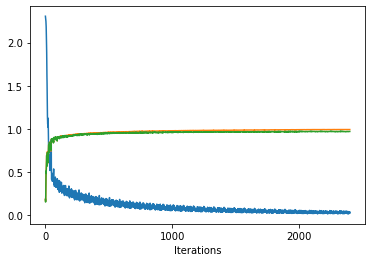

In [21]:
# Plotting cost and training accuracy over iterations. COMMENT WHEN IN INFERENCE MODE.
%matplotlib inline
x_ticks= [i for i in range(0, len(cost_history), 1000)]
plt.plot(cost_history)
plt.xticks(x_ticks)
plt.xlabel("Iterations")
plt.plot(train_acc)
plt.plot(dev_acc)
plt.savefig('Training_Graph.png')


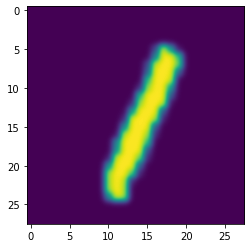

That's 1


In [19]:
# Loading random example from dev set and predicting it
eg= random.randint(0, m-m_train)
plt.imshow(np.reshape(X_dev[:, eg], (28,28)), interpolation='gaussian')
plt.show()
example= np.reshape(X_dev[:, eg], (784,1))
hehe = forw_prop(example, layer_data, params)
prediction, _, _, _= hehe[len(hehe)-1]
prediction= np.squeeze(np.argmax(prediction, axis=0))
print("That's", prediction)

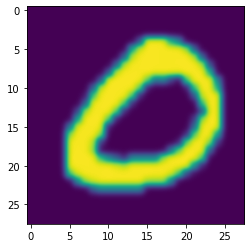

That's 0


In [20]:
# Loading random Test set examples to evaluate performance
X_test= np.array(pd.read_csv(r'E:\My files\Python\DL\Datasets\MNIST\test.csv'))
X_test= np.transpose(X_test)
X_test=X_test/255

eg= random.randint(0, np.shape(X_test)[1])

plt.imshow(np.reshape(X_test[:, eg], (28,28)), interpolation='gaussian')
plt.show()
example= np.reshape(X_test[:, eg], (784,1))
hehe = forw_prop(example, layer_data, params)
prediction, _, _, _= hehe[len(hehe)-1]
prediction= np.squeeze(np.argmax(prediction, axis=0))
print("That's", prediction)

In [ ]:
# Saving trained weights
print(params)
with open('filename.json', 'wb') as fp:
    pickle.dump(params, fp)
    
with open('filename.json', 'rb') as fp:
    data=pickle.load(fp)

print(data)